In [ ]:
import datasets.eurosat
import datasets.core

import torch
from torch import nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import einops.einops as einops

# Replicating original EuroSAT paper

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [3]:
resize_transform = datasets.core.tensor_dict_transform_wrapper(transforms.Compose([
    # transforms.Resize((224, 224), antialias=False),  # authors rescale images
    datasets.core.ClampTransform()
]))

In [4]:
eurosat_train_ds = datasets.eurosat.get_dataset("train", transforms=resize_transform)
eurosat_test_ds = datasets.eurosat.get_dataset("test", transforms=resize_transform)
print(f"There are {len(eurosat_train_ds)} training samples and {len(eurosat_test_ds)} test samples.")

There are 16200 training samples and 5400 test samples.


In [5]:
eurosat_train_ds[0]["image"]

tensor([[[0.5818, 0.5818, 0.5778,  ..., 0.3949, 0.4062, 0.4000],
         [0.5818, 0.5818, 0.5778,  ..., 0.3949, 0.4062, 0.4000],
         [0.5636, 0.5636, 0.5622,  ..., 0.4000, 0.4007, 0.4011],
         ...,
         [0.5538, 0.5538, 0.5487,  ..., 0.4007, 0.3949, 0.3953],
         [0.5164, 0.5164, 0.5025,  ..., 0.4084, 0.4105, 0.4193],
         [0.4778, 0.4778, 0.4676,  ..., 0.4095, 0.4145, 0.4258]],

        [[0.4695, 0.4695, 0.4658,  ..., 0.3556, 0.3571, 0.3593],
         [0.4695, 0.4695, 0.4658,  ..., 0.3556, 0.3571, 0.3593],
         [0.4571, 0.4571, 0.4589,  ..., 0.3600, 0.3567, 0.3556],
         ...,
         [0.4524, 0.4524, 0.4455,  ..., 0.3553, 0.3535, 0.3560],
         [0.4353, 0.4353, 0.4305,  ..., 0.3640, 0.3669, 0.3720],
         [0.4153, 0.4153, 0.4058,  ..., 0.3691, 0.3687, 0.3756]],

        [[0.4695, 0.4695, 0.4655,  ..., 0.3938, 0.3993, 0.3953],
         [0.4695, 0.4695, 0.4655,  ..., 0.3938, 0.3993, 0.3953],
         [0.4615, 0.4615, 0.4665,  ..., 0.3975, 0.3927, 0.

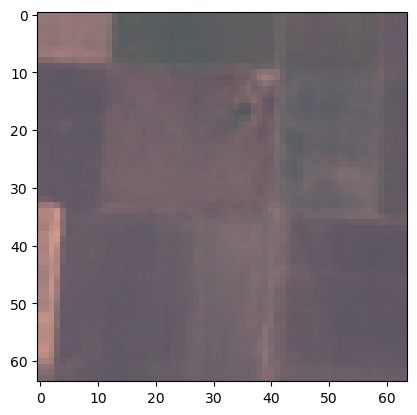

In [7]:
plt.imshow(einops.rearrange(eurosat_train_ds[0]["image"], "c h w -> h w c"))

## Basic CNN

In [ ]:
class BaseCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_unit = nn.Sequential(
            nn.Conv2d()
        )